In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gymnasium import spaces
from tqdm import trange
import gymnasium as gym
from torch_geometric.data import Data, Batch
import os
import os.path as osp
from typing import Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
import torch.optim as optim
import random
import yfinance as yf
import wikipedia as wp

In [13]:
!nvidia-smi

Thu Oct 31 16:17:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:BD:00.0 Off |                    0 |
| N/A   37C    P0    74W / 400W |  81122MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import os.path as osp
from typing import Callable

from torch_geometric.data import Dataset, Data

def get_graph_in_pyg_format(values_path: str, adj_path: str) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Creates the PyTorch Geometric graph data from the stock price data and adjacency matrix.
    :param values_path: Path of the CSV file containing the stock price data
    :param adj_path: Path of the NumPy file containing the adjacency matrix
    :return: The graph data in PyTorch Geometric format
        x: Node features (nodes_nb, timestamps_nb, features_nb)
        close_prices: Close prices (nodes_nb, timestamps_nb)
        edge_index: Edge index (2, edge_nb)
        edge_weight: Edge weight (edge_nb,)
    """
    values = pd.read_csv(values_path).set_index(['Symbol', 'Date'])
    adj = np.load(adj_path)
    nodes_nb, edge_nb = len(adj), np.count_nonzero(adj)
    x = torch.tensor(
        values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1] - 1)), dtype=torch.float32
    )
    x = x.transpose(1, 2)
    close_prices = torch.tensor(
        values[["Close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
    )
    edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long), torch.zeros((edge_nb,), dtype=torch.float32)
    count = 0
    for i in range(nodes_nb):
        for j in range(nodes_nb):
            if (weight := adj[i, j]) != 0:
                edge_index[0, count], edge_index[1, count] = i, j
                edge_weight[count] = weight
                count += 1

    return x, close_prices, edge_index, edge_weight


def get_stocks_labels() -> list[str]:
    """
    Retrieves the labels (symbols) of the dataset stocks
    :return: The list of stock labels
    """
    return pd.read_csv("../GNN-Stock/huggingface-dataset/test_3090/raw/S&P500_values.csv")["Symbol"].unique().tolist()



class SP100Stocks(Dataset):
    """
    Stock price data.
    The graph data built from the notebooks is used.
    """

    def __init__(self, root: str = "../GNN-Stock/huggingface-dataset/test_3090/",  # Use output directory
                 values_file_name: str = "S&P500_values.csv",
                 adj_file_name: str = "adj.npy", past_window: int = 25,
                 future_window: int = 1, force_reload: bool = False,
                 transform: Callable = None):
        self.values_file_name = values_file_name
        self.adj_file_name = adj_file_name
        self.past_window = past_window
        self.future_window = future_window

        super().__init__(root, force_reload=force_reload, transform=transform)

    @property
    def raw_file_names(self) -> list[str]:
        return [
            self.values_file_name, self.adj_file_name
        ]

    @property
    def processed_file_names(self) -> list[str]:
        return [
            f'timestep_{idx}.pt' for idx in range(self.len())
        ]

    def download(self) -> None:
        pass

    def process(self) -> None:
        x, close_prices, edge_index, edge_weight = get_graph_in_pyg_format(
            values_path=osp.join("../GNN-Stock/huggingface-dataset/test_3090/raw/", self.values_file_name), 
            adj_path=osp.join("../GNN-Stock/huggingface-dataset/test_3090/raw/", self.adj_file_name),
        )
        timestamps = [
            Data(
                x=x[:, :, idx:idx + self.past_window],
                edge_index=edge_index,
                edge_weight=edge_weight,
                close_price=close_prices[:, idx:idx + self.past_window],
                y=x[:, 0, idx + self.past_window:idx + self.past_window + self.future_window],
                close_price_y=close_prices[:, idx + self.past_window:idx + self.past_window + self.future_window],
            ) for idx in range(x.shape[2] - self.past_window - self.future_window)
        ]
        for t, timestep in enumerate(timestamps):
            try:
                torch.save(timestep, osp.join(self.processed_dir, f"ts_{t}_.pt"))
            except Exception as e:
                print(f"Error saving timestep {t}: {e}")

    def len(self) -> int:
        values = pd.read_csv(self.raw_paths[0]).set_index(['Symbol', 'Date'])
        return len(values.loc[values.index[0][0]]) - self.past_window - self.future_window

    def get(self, idx: int) -> Data:
        data = torch.load(osp.join(self.processed_dir, f'ts_{idx}_.pt'))
        return data

In [4]:
seq_len = 14
dataset = SP100Stocks(past_window=seq_len, force_reload=True)
dataset, dataset[0]

Processing...


KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import confusion_matrix
from datetime import datetime
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader
from tqdm import trange

def get_regression_error(model: nn.Module, dataloader: DataLoader, device) -> tuple[float, float, float, float]:
    """
    Computes regression errors
    :param model: Model to test
    :param dataloader: Dataloader to test on
    :return: Mean squared error, rooted mean squared error, mean absolute error, mean relative error
    """
    mse = 0
    rmse = 0
    mae = 0
    mre = 0
    for data in dataloader:
        data = data.to(device)  # Move data to the correct device
        out = model(data.x, data.edge_index, data.edge_weight)
        mse += F.mse_loss(out, data.y).item()
        rmse += F.mse_loss(out, data.y).sqrt().item()
        mae += F.l1_loss(out, data.y).item()
        mre += (F.l1_loss(out, data.y) / data.y.abs().mean()).item()
    return mse / len(dataloader), rmse / len(dataloader), mae / len(dataloader), mre / len(dataloader)


def plot_regression(model: nn.Module, data: Data, title: str = None, device = 'cpu') -> None:
    """
    Plot 4 graphs for regression
    :param model: Model to test
    :param data: Data to test on
    :param title: Title of the plot
    """
    model.eval()
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title)
    data = data.to(device)  # Move data to the correct device
    out = model(data.x, data.edge_index, data.edge_weight)
    stocks_idx = np.random.choice(data.x.shape[0] // (len(data.ptr) - 1), 4)

    preds = out.reshape(len(data.ptr) - 1, -1)
    target = data.y.reshape(len(data.ptr) - 1, -1)

    for idx, stock_idx in enumerate(stocks_idx):
        ax = axs[idx // 2, idx % 2]
        ax.plot(target[:, stock_idx].detach().cpu().numpy(), label="Real")
        ax.plot(preds[:, stock_idx].detach().cpu().numpy(), label="Predicted")
        ax.set_title(f"Stock {stock_idx}")
        ax.legend()

    plt.show()


def measure_accuracy(model: nn.Module, data: Data, device='cpu') -> float:
    """
    Measure accuracy
    :param model: Model to test
    :param data: Data to test on
    :return: Accuracy
    """
    data = data.to(device)  # Move data to the correct device
    out = model(data.x, data.edge_index, data.edge_weight)
    if out.shape[1] == 1:  # Binary classification
        return (F.sigmoid(out).round() == data.y).sum().item() / len(data.y)
    else:  # Multi-class classification
        return (F.softmax(out, dim=-1).argmax(dim=-1) == data.y).sum().item() / len(data.y)

def validate_iteration(model: nn.Module, criterion: nn.Module, val_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False, device='cpu') -> tuple[float, float]:
    """
    Validation iteration
    """
    model.eval()
    total_loss = 0
    total_acc = 0
    num_batches = len(val_dataloader)

    with torch.no_grad():
        for idx, data in enumerate(val_dataloader):
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_weight)
            loss = criterion(out, data.y)
            writer.add_scalar("Loss/Validation Loss", loss.item(), epoch * len(val_dataloader) + idx)
            total_loss += loss.item()

            if measure_acc:
                acc = measure_accuracy(model, data, device)  # Assuming you have measure_accuracy defined
                writer.add_scalar("Accuracy/Validation Accuracy", acc, epoch * len(val_dataloader) + idx)
                total_acc += acc


    return total_loss / num_batches, total_acc / num_batches



def get_confusion_matrix(model: nn.Module, data: Data, device='cpu') -> np.ndarray:
    """
    Get confusion matrix
    :param model: Model to test
    :param data: Data to test on
    :return: Confusion matrix
    """
    data = data.to(device)
    out = model(data.x, data.edge_index, data.edge_weight)
    if out.shape[1] == 1:
        y_pred = F.sigmoid(out).round().detach().cpu().numpy()  # Move tensor to CPU before converting to NumPy
    else:
        y_pred = F.softmax(out, dim=-1).argmax(dim=-1).detach().cpu().numpy()
    y_true = data.y.detach().cpu().numpy()
    return confusion_matrix(y_true, y_pred)


def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, 
          train_dataloader: DataLoader, val_dataloader: DataLoader, test_dataloader: DataLoader, 
          num_epochs: int, task_title: str = "", measure_acc: bool = False, device='cpu') -> None:

    writer = SummaryWriter(f'runs/{task_title}_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in (pbar := trange(num_epochs, desc="Epochs")):
        train_loss, train_acc = train_iteration(model, optimizer, pbar, criterion, train_dataloader, epoch, writer, measure_acc, device)
        val_loss, val_acc = validate_iteration(model, criterion, val_dataloader, epoch, writer, measure_acc, device)
        test_loss, test_acc = test_iteration(model, criterion, test_dataloader, epoch, writer, measure_acc, device)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f},"
              f"Val Loss: {val_loss:.4f},"
              f"Test Loss: {test_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()


    # Save the best model's state dictionary
    if best_model_state_dict is not None:
      model_save_path = f"best_model/{task_title}_{datetime.now().strftime('%d_%m_%Hh%M')}_{model.__class__.__name__}.pt"
      torch.save(best_model_state_dict, model_save_path)
      print(f"Best model saved to: {model_save_path}")
        
    writer.close()
    # Evaluate and plot after training
    if test_dataloader is not None and len(test_dataloader) > 0:  # Check if test_dataloader is available and not empty
      mse, rmse, mae, mre = get_regression_error(model, test_dataloader, device)
      print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

      for test_data in test_dataloader:  # Get one batch of data
        plot_regression(model, test_data, title=f"Regression Plots - {task_title}", device=device)
        break


def test_iteration(model: nn.Module, criterion: nn.Module, test_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False, device='cpu') -> tuple[float, float]:
    """
    Test iteration
    """
    model.eval()
    total_loss = 0
    total_acc = 0
    num_batches = len(test_dataloader) # Important: Calculate this *before* the loop in case test_dataloader is empty


    with torch.no_grad():
        for idx, data in enumerate(test_dataloader):  
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_weight)
            loss = criterion(out, data.y)
            writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)
            total_loss += loss.item()

            if measure_acc:
                acc = measure_accuracy(model, data, device) # Assuming you have measure_accuracy defined
                writer.add_scalar("Accuracy/Test Accuracy", acc, epoch * len(test_dataloader) + idx)
                total_acc += acc


    # Handle the case where the test_dataloader is empty (this avoids division by zero):
    if num_batches == 0:
        return 0.0, 0.0  # Or handle as appropriate (e.g., return NaN, raise an exception)
    else:
        return total_loss / num_batches, total_acc / num_batches


def train_iteration(model: nn.Module, optimizer: optim.Optimizer, pbar: trange, criterion: nn.Module, train_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False, device='cpu') -> tuple[float, float]:
    """
    Train iteration
    :param model: Model to train
    :param optimizer: Optimizer to use (Adam, ...)
    :param pbar: tqdm progress bar
    :param criterion: Loss function to use (MSE, CrossEntropy, ...)
    :param train_dataloader: Train data loader
    :param epoch: Current epoch
    :param writer: Tensorboard writer
    :param measure_acc: Whether to measure accuracy or not (for classification tasks)
    """
    model.train()
    total_loss = 0
    total_acc = 0
    num_batches = len(train_dataloader)

    for idx, data in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"Batch": f"{(idx + 1) / len(train_dataloader) * 100:.1f}%"})
        writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
        total_loss += loss.item()

        if measure_acc:
            acc = measure_accuracy(model, data, device)  
            writer.add_scalar("Accuracy/Train Accuracy", acc, epoch * len(train_dataloader) + idx)
            total_acc += acc

    return total_loss / num_batches, total_acc / num_batches


In [7]:
class GCN(nn.Module):
    """
    Simple two-layer GCN model.
    """
    def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
        super(GCN, self).__init__()
        layer_sizes = layer_sizes or [32, 32]
        self.convs = nn.ModuleList([
            GCNConv(in_channels, layer_sizes[0], bias=bias),
        ] + [
            GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias) for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the GCN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
        """
        # Infer device from input tensor
        device = x.device
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_weight))
        return x

class GAT(nn.Module):
    """
    Simple two-layer GAT model.
    """
    def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
        super(GAT, self).__init__()
        layer_sizes = layer_sizes or [32, 32]
        self.convs = nn.ModuleList([
           GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
        ] + [
           GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the GAT model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
        """
        # Infer device from input tensor
        device = x.device
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index, edge_weight))
        return self.convs[-1](x, edge_index, edge_weight)

class TGCNCell(nn.Module):
    """
    T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
    """
    def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
        super(TGCNCell, self).__init__()
        if use_gat:
            self.gcn = GAT(in_channels, [hidden_size, hidden_size])
        else:
            self.gcn = GCN(in_channels, [hidden_size, hidden_size])
        self.lin_u = nn.Linear(2 * hidden_size + in_channels, hidden_size)
        self.lin_r = nn.Linear(2 * hidden_size + in_channels, hidden_size)
        self.lin_c = nn.Linear(2 * hidden_size + in_channels, hidden_size)

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on a single T-GCN cell (GCN + GRU).
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
        :return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
        """
        # Infer device from input tensor
        device = x.device
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)
        h = h.to(device)

        gcn_out = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
        u = F.sigmoid(self.lin_u(torch.cat([x, gcn_out, h], dim=-1)))  # u_t, Eq. 3
        r = F.sigmoid(self.lin_r(torch.cat([x, gcn_out, h], dim=-1)))  # r_t,  Eq. 4
        c = F.tanh(self.lin_c(torch.cat([x, gcn_out, r * h], dim=-1)))  # c_t, Eq. 5

        return u * h + (1 - u) * c  # h_t, Eq. 6

class TGCN(nn.Module):
    """
    T-GCN model from https://arxiv.org/pdf/1811.05320.
    """
    def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
        super(TGCN, self).__init__()
        self.hidden_size = hidden_size
        self.layers_nb = max(1, layers_nb)
        self.cells = nn.ModuleList(
            [TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size, out_channels),
            output_activation if output_activation is not None else nn.Identity(),
        )

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the T-GCN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The output of the model (Nodes_nb, OutFeatures_nb)
        """
        # Infer device from input tensor
        device = x.device
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        h_prev = [
            torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
        ]
        for t in range(x.shape[-1]):
            h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
            for i, cell in enumerate(self.cells):
                h = cell(h, edge_index, edge_weight, h_prev[i])
                h_prev[i] = h
        return self.out(h_prev[-1])

class A3TGCN(nn.Module):
    """
    A3T-GCN model from https://arxiv.org/pdf/2006.11583.
    """
    def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
        super(A3TGCN, self).__init__()
        self.hidden_size = hidden_size
        self.layers_nb = max(1, layers_nb)
        self.cells = nn.ModuleList(
            [TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1),
        )
        nn.init.uniform_(self.attention[0].weight)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, out_channels),
            output_activation if output_activation is not None else nn.Identity(),
        )

    def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
        """
        Performs a forward pass on the A3T-GCN model.
        :param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
        :param edge_index: The edge index of the graph A (2, Edges_nb)
        :param edge_weight: The edge weight of the graph (Edges_nb,)
        :return: The output of the model (Nodes_nb, OutFeatures_nb)
        """
        # Infer device from input tensor
        device = x.device
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)

        h_prev = [
            torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
        ]
        h_final = torch.zeros(x.shape[0], x.shape[-1], self.hidden_size).to(device)
        for t in range(x.shape[-1]):
            h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
            for i, cell in enumerate(self.cells):
                h = cell(h, edge_index, edge_weight, h_prev[i])
                h_prev[i] = h
            h_final[:, t, :] = h
        att = self.attention(h_final)
        c_t = self.out(torch.sum(h_final * att, dim=1))
        return c_t

In [ ]:
from torch_geometric.loader import DataLoader

train_part = 0.8
val_part = 0.1
batch_size = 4

train_split = int(train_part * len(dataset))
val_split = int((train_part + val_part) * len(dataset))

train_dataset = dataset[:train_split]
val_dataset = dataset[train_split:val_split]
test_dataset = dataset[val_split:]

print(f"Train dataset: {len(train_dataset)}, Validation dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=True).to(device)

model = model.to(device)

lr, weight_decay, num_epochs = 0.005, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Epochs:   6%|▋         | 1/16 [01:00<14:59, 59.98s/it, Batch=0.6%]  

Epoch 1/16, Train Loss: 0.1142,Val Loss: 0.0267,Test Loss: 0.0482


Epochs:  12%|█▎        | 2/16 [01:39<11:14, 48.19s/it, Batch=100.0%]

Epoch 2/16, Train Loss: 0.0243,Val Loss: 0.0194,Test Loss: 0.0340


Epochs:  19%|█▉        | 3/16 [02:09<08:37, 39.82s/it, Batch=0.6%]  

Epoch 3/16, Train Loss: 0.0227,Val Loss: 0.0195,Test Loss: 0.0310


Epochs:  25%|██▌       | 4/16 [02:47<07:47, 38.98s/it, Batch=0.6%]  

Epoch 4/16, Train Loss: 0.0202,Val Loss: 0.0177,Test Loss: 0.0290


Epochs:  31%|███▏      | 5/16 [03:23<06:58, 38.01s/it, Batch=0.6%]  

Epoch 5/16, Train Loss: 0.0200,Val Loss: 0.0163,Test Loss: 0.0278


Epochs:  38%|███▊      | 6/16 [04:02<06:21, 38.15s/it, Batch=0.6%]  

Epoch 6/16, Train Loss: 0.0179,Val Loss: 0.0155,Test Loss: 0.0233


Epochs:  44%|████▍     | 7/16 [04:41<05:47, 38.63s/it, Batch=0.6%]  

Epoch 7/16, Train Loss: 0.0183,Val Loss: 0.0275,Test Loss: 0.0445


Epochs:  50%|█████     | 8/16 [05:21<05:10, 38.84s/it, Batch=100.0%]

Epoch 8/16, Train Loss: 0.0180,Val Loss: 0.0151,Test Loss: 0.0203


Epochs:  56%|█████▋    | 9/16 [05:57<04:26, 38.13s/it, Batch=0.6%]  

Epoch 9/16, Train Loss: 0.0167,Val Loss: 0.0247,Test Loss: 0.0370


Epochs:  62%|██████▎   | 10/16 [06:36<03:49, 38.23s/it, Batch=100.0%]

Epoch 10/16, Train Loss: 0.0167,Val Loss: 0.0177,Test Loss: 0.0271


Epochs:  69%|██████▉   | 11/16 [07:12<03:07, 37.55s/it, Batch=0.6%]  

Epoch 11/16, Train Loss: 0.0171,Val Loss: 0.0184,Test Loss: 0.0282


Epochs:  75%|███████▌  | 12/16 [07:47<02:27, 36.79s/it, Batch=0.6%]  

Epoch 12/16, Train Loss: 0.0173,Val Loss: 0.0146,Test Loss: 0.0229


Epochs:  81%|████████▏ | 13/16 [08:25<01:51, 37.14s/it, Batch=100.0%]

Epoch 13/16, Train Loss: 0.0164,Val Loss: 0.0161,Test Loss: 0.0209


Epochs:  88%|████████▊ | 14/16 [09:03<01:15, 37.52s/it, Batch=0.6%]  

Epoch 14/16, Train Loss: 0.0164,Val Loss: 0.0153,Test Loss: 0.0232


Epochs:  94%|█████████▍| 15/16 [09:42<00:37, 37.87s/it, Batch=0.6%]  

Epoch 15/16, Train Loss: 0.0163,Val Loss: 0.0149,Test Loss: 0.0198


Epochs: 100%|██████████| 16/16 [10:21<00:00, 38.82s/it, Batch=100.0%]

Epoch 16/16, Train Loss: 0.0168,Val Loss: 0.0165,Test Loss: 0.0281
Best model saved to: best_model_PriceForecastingSP500_A3TGCN.pt


Test MSE: 0.0281, RMSE: 0.1677, MAE: 0.1209, MRE: 0.0971


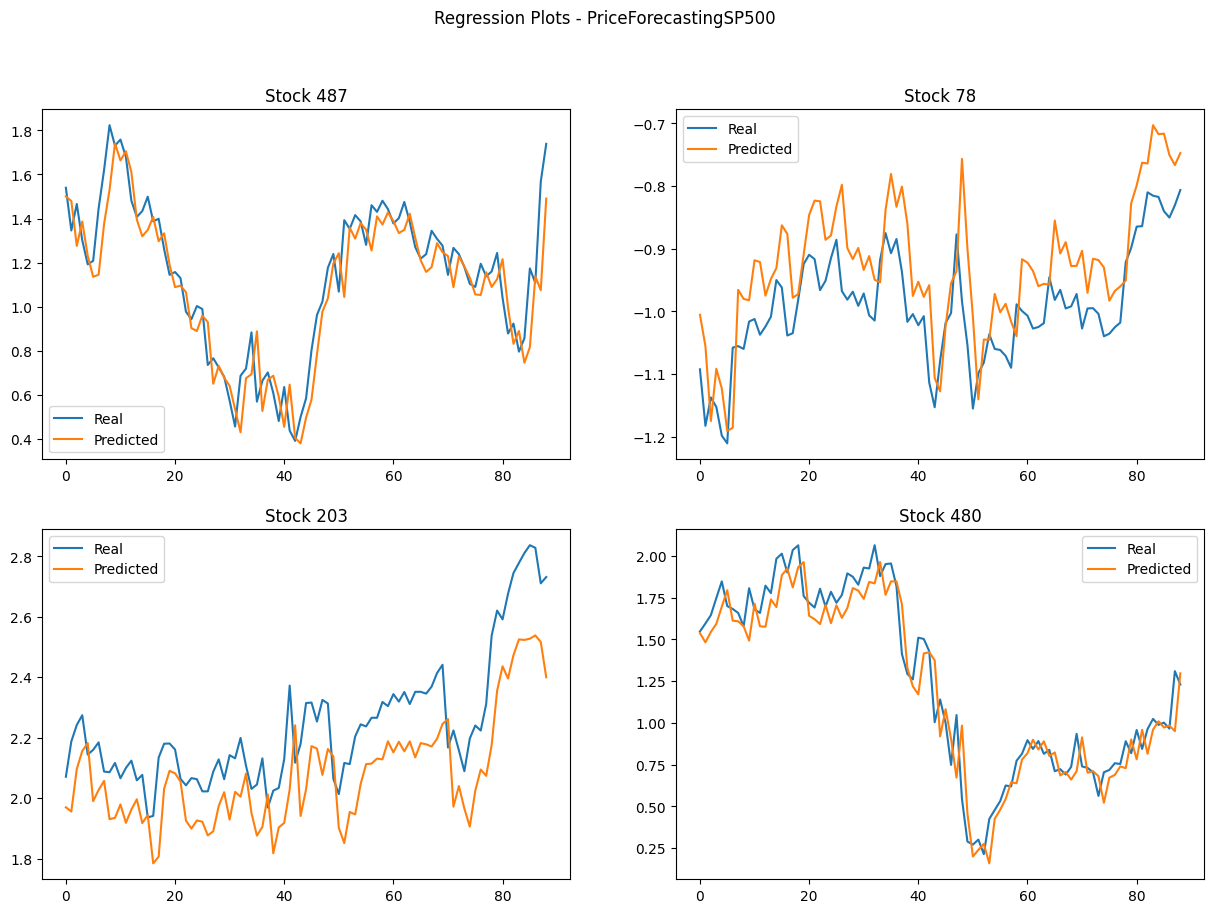

In [9]:
train(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, num_epochs, "PriceForecastingSP500", device=device)

In [10]:
mse, rmse, mae, mre = get_regression_error(model, train_dataloader, device=device)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, RMSE: {mae:.4f}, MRE: {mre:.4f}")

Train MSE: 0.0150, RMSE: 0.1205, MAE: 0.0845, MRE: 0.1181


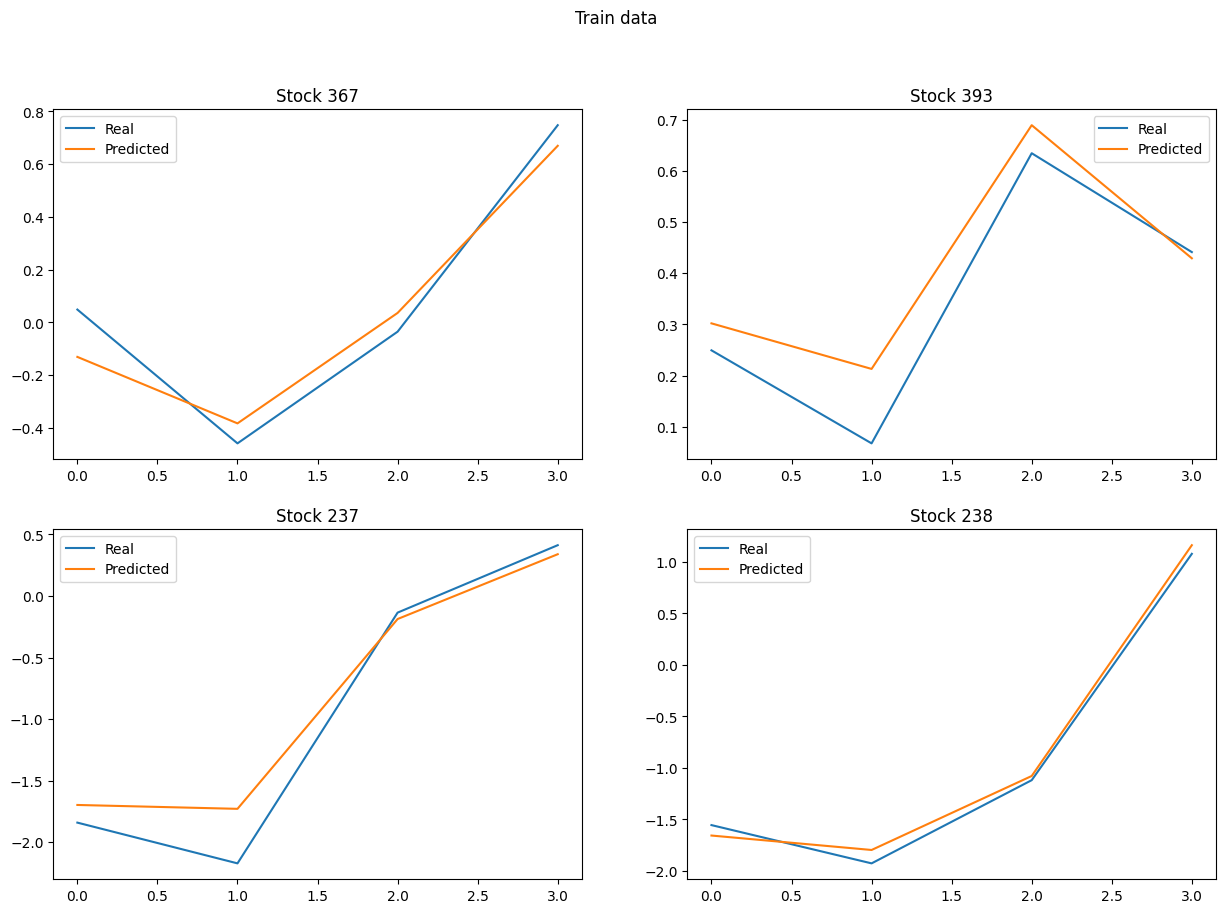

In [12]:
plot_regression(model, next(iter(train_dataloader)), "Train data", device = device)

In [ ]:
mse, rmse, mae, mre = get_regression_error(model, test_dataloader, device=device)
print(f"test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

In [ ]:
plot_regression(model, next(iter(test_dataloader)), "Test data", device=device)

In [13]:
def future_close_price_to_buy_sell_class(sample: Data):
	"""
	Transforms the target y to a binary buy (1) if the stock return two weeks ahead was higher that the average market return, else sell (0)
	:param sample: Data sample
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	sample.y = (sample.returns >= 0).float()
	return sample

In [14]:
weeks_ahead = 5

dataset = SP100Stocks(past_window = 20,future_window=weeks_ahead * 1, force_reload=True, transform=future_close_price_to_buy_sell_class)
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(874),
 Data(x=[491, 8, 20], edge_index=[2, 4794], y=[491, 1], edge_weight=[4794], close_price=[491, 20], close_price_y=[491, 5], returns=[491, 1], market_return=0.01452337484806776))

In [16]:
from torch_geometric.loader import DataLoader

train_part = 0.8  

val_part = 0.1
batch_size = 64

train_split = int(train_part * len(dataset))
val_split = int((train_part + val_part) * len(dataset))

train_dataset = dataset[:train_split]
val_dataset = dataset[train_split:val_split]
test_dataset = dataset[val_split:]

print(f"Train dataset: {len(train_dataset)}, Validation dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 699, Validation dataset: 87, Test dataset: 88


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

in_channels, out_channels, hidden_size, layers_nb, dropout = dataset[0].x.shape[-2], 1, 16, 2, .3
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb).to(device)

lr, weight_decay, num_epochs = 0.005, 1e-5, 50
	
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Using device: cuda


Epochs:   2%|▏         | 1/50 [00:43<35:42, 43.72s/it, Batch=100.0%]

Epoch 1/50, Train Loss: 0.6897,Val Loss: 0.6901,Test Loss: 0.7009


Epochs:   4%|▍         | 2/50 [01:05<24:43, 30.90s/it, Batch=100.0%]

Epoch 2/50, Train Loss: 0.6857,Val Loss: 0.7124,Test Loss: 0.7224


Epochs:   6%|▌         | 3/50 [01:33<23:14, 29.67s/it, Batch=100.0%]

Epoch 3/50, Train Loss: 0.6846,Val Loss: 0.7013,Test Loss: 0.7178


Epochs:   8%|▊         | 4/50 [01:55<20:20, 26.54s/it, Batch=100.0%]

Epoch 4/50, Train Loss: 0.6839,Val Loss: 0.7037,Test Loss: 0.7173


Epochs:  10%|█         | 5/50 [02:16<18:17, 24.38s/it, Batch=100.0%]

Epoch 5/50, Train Loss: 0.6835,Val Loss: 0.7120,Test Loss: 0.7284


Epochs:  12%|█▏        | 6/50 [02:38<17:19, 23.63s/it, Batch=100.0%]

Epoch 6/50, Train Loss: 0.6827,Val Loss: 0.7002,Test Loss: 0.7152


Epochs:  14%|█▍        | 7/50 [03:01<16:53, 23.58s/it, Batch=100.0%]

Epoch 7/50, Train Loss: 0.6839,Val Loss: 0.7444,Test Loss: 0.7512


Epochs:  16%|█▌        | 8/50 [03:22<15:56, 22.77s/it, Batch=100.0%]

Epoch 8/50, Train Loss: 0.6896,Val Loss: 0.6953,Test Loss: 0.7068


Epochs:  18%|█▊        | 9/50 [03:41<14:45, 21.59s/it, Batch=100.0%]

Epoch 9/50, Train Loss: 0.6869,Val Loss: 0.7067,Test Loss: 0.7158


Epochs:  20%|██        | 10/50 [03:59<13:30, 20.26s/it, Batch=100.0%]

Epoch 10/50, Train Loss: 0.6830,Val Loss: 0.7062,Test Loss: 0.7240


Epochs:  22%|██▏       | 11/50 [04:19<13:11, 20.29s/it, Batch=100.0%]

Epoch 11/50, Train Loss: 0.6820,Val Loss: 0.7107,Test Loss: 0.7267


Epochs:  24%|██▍       | 12/50 [04:38<12:37, 19.94s/it, Batch=100.0%]

Epoch 12/50, Train Loss: 0.6808,Val Loss: 0.7070,Test Loss: 0.7238


Epochs:  26%|██▌       | 13/50 [04:58<12:12, 19.79s/it, Batch=100.0%]

Epoch 13/50, Train Loss: 0.6798,Val Loss: 0.7147,Test Loss: 0.7324


Epochs:  28%|██▊       | 14/50 [05:12<10:56, 18.24s/it, Batch=100.0%]

Epoch 14/50, Train Loss: 0.6795,Val Loss: 0.7209,Test Loss: 0.7364


Epochs:  30%|███       | 15/50 [05:31<10:48, 18.52s/it, Batch=100.0%]

Epoch 15/50, Train Loss: 0.6784,Val Loss: 0.7170,Test Loss: 0.7380


Epochs:  32%|███▏      | 16/50 [05:50<10:34, 18.67s/it, Batch=100.0%]

Epoch 16/50, Train Loss: 0.6795,Val Loss: 0.6931,Test Loss: 0.7182


Epochs:  34%|███▍      | 17/50 [06:09<10:17, 18.70s/it, Batch=100.0%]

Epoch 17/50, Train Loss: 0.6785,Val Loss: 0.7130,Test Loss: 0.7291


Epochs:  36%|███▌      | 18/50 [06:30<10:16, 19.26s/it, Batch=100.0%]

Epoch 18/50, Train Loss: 0.6768,Val Loss: 0.7162,Test Loss: 0.7388


Epochs:  38%|███▊      | 19/50 [06:48<09:43, 18.82s/it, Batch=100.0%]

Epoch 19/50, Train Loss: 0.6785,Val Loss: 0.7033,Test Loss: 0.7247


Epochs:  40%|████      | 20/50 [07:08<09:43, 19.44s/it, Batch=100.0%]

Epoch 20/50, Train Loss: 0.6770,Val Loss: 0.7295,Test Loss: 0.7419


Epochs:  42%|████▏     | 21/50 [07:28<09:28, 19.62s/it, Batch=100.0%]

Epoch 21/50, Train Loss: 0.6778,Val Loss: 0.7077,Test Loss: 0.7239


Epochs:  44%|████▍     | 22/50 [07:45<08:41, 18.64s/it, Batch=100.0%]

Epoch 22/50, Train Loss: 0.6766,Val Loss: 0.7065,Test Loss: 0.7324


Epochs:  46%|████▌     | 23/50 [08:06<08:46, 19.48s/it, Batch=100.0%]

Epoch 23/50, Train Loss: 0.6754,Val Loss: 0.7001,Test Loss: 0.7194


Epochs:  48%|████▊     | 24/50 [08:25<08:21, 19.29s/it, Batch=100.0%]

Epoch 24/50, Train Loss: 0.6743,Val Loss: 0.7196,Test Loss: 0.7367


Epochs:  50%|█████     | 25/50 [08:46<08:16, 19.88s/it, Batch=100.0%]

Epoch 25/50, Train Loss: 0.6743,Val Loss: 0.7143,Test Loss: 0.7329


Epochs:  52%|█████▏    | 26/50 [09:05<07:47, 19.49s/it, Batch=100.0%]

Epoch 26/50, Train Loss: 0.6732,Val Loss: 0.7075,Test Loss: 0.7290


Epochs:  54%|█████▍    | 27/50 [09:24<07:25, 19.36s/it, Batch=100.0%]

Epoch 27/50, Train Loss: 0.6721,Val Loss: 0.7096,Test Loss: 0.7335


Epochs:  56%|█████▌    | 28/50 [09:44<07:07, 19.43s/it, Batch=100.0%]

Epoch 28/50, Train Loss: 0.6740,Val Loss: 0.7138,Test Loss: 0.7268


Epochs:  58%|█████▊    | 29/50 [10:06<07:06, 20.29s/it, Batch=100.0%]

Epoch 29/50, Train Loss: 0.6717,Val Loss: 0.7176,Test Loss: 0.7346


Epochs:  60%|██████    | 30/50 [10:25<06:39, 19.97s/it, Batch=100.0%]

Epoch 30/50, Train Loss: 0.6693,Val Loss: 0.7036,Test Loss: 0.7291


Epochs:  62%|██████▏   | 31/50 [10:45<06:18, 19.92s/it, Batch=100.0%]

Epoch 31/50, Train Loss: 0.6679,Val Loss: 0.7143,Test Loss: 0.7351


Epochs:  64%|██████▍   | 32/50 [11:04<05:52, 19.58s/it, Batch=100.0%]

Epoch 32/50, Train Loss: 0.6670,Val Loss: 0.7127,Test Loss: 0.7346


Epochs:  66%|██████▌   | 33/50 [11:23<05:29, 19.38s/it, Batch=100.0%]

Epoch 33/50, Train Loss: 0.6656,Val Loss: 0.7060,Test Loss: 0.7296


Epochs:  68%|██████▊   | 34/50 [11:38<04:49, 18.08s/it, Batch=100.0%]

Epoch 34/50, Train Loss: 0.6717,Val Loss: 0.7169,Test Loss: 0.7262


Epochs:  70%|███████   | 35/50 [11:56<04:33, 18.20s/it, Batch=100.0%]

Epoch 35/50, Train Loss: 0.6717,Val Loss: 0.7060,Test Loss: 0.7256


Epochs:  72%|███████▏  | 36/50 [12:15<04:17, 18.40s/it, Batch=100.0%]

Epoch 36/50, Train Loss: 0.6660,Val Loss: 0.7225,Test Loss: 0.7488


Epochs:  74%|███████▍  | 37/50 [12:34<04:00, 18.53s/it, Batch=100.0%]

Epoch 37/50, Train Loss: 0.6660,Val Loss: 0.7200,Test Loss: 0.7367


Epochs:  76%|███████▌  | 38/50 [12:53<03:45, 18.83s/it, Batch=100.0%]

Epoch 38/50, Train Loss: 0.6669,Val Loss: 0.7252,Test Loss: 0.7439


Epochs:  78%|███████▊  | 39/50 [13:13<03:30, 19.12s/it, Batch=100.0%]

Epoch 39/50, Train Loss: 0.6657,Val Loss: 0.7200,Test Loss: 0.7367


Epochs:  80%|████████  | 40/50 [13:33<03:12, 19.29s/it, Batch=100.0%]

Epoch 40/50, Train Loss: 0.6628,Val Loss: 0.7100,Test Loss: 0.7310


Epochs:  82%|████████▏ | 41/50 [13:51<02:51, 19.10s/it, Batch=100.0%]

Epoch 41/50, Train Loss: 0.6624,Val Loss: 0.7067,Test Loss: 0.7327


Epochs:  84%|████████▍ | 42/50 [14:10<02:31, 19.00s/it, Batch=100.0%]

Epoch 42/50, Train Loss: 0.6621,Val Loss: 0.7092,Test Loss: 0.7286


Epochs:  86%|████████▌ | 43/50 [14:29<02:12, 18.98s/it, Batch=100.0%]

Epoch 43/50, Train Loss: 0.6616,Val Loss: 0.7099,Test Loss: 0.7339


Epochs:  88%|████████▊ | 44/50 [14:47<01:52, 18.77s/it, Batch=100.0%]

Epoch 44/50, Train Loss: 0.6598,Val Loss: 0.7045,Test Loss: 0.7265


Epochs:  90%|█████████ | 45/50 [15:04<01:30, 18.08s/it, Batch=100.0%]

Epoch 45/50, Train Loss: 0.6583,Val Loss: 0.7258,Test Loss: 0.7477


Epochs:  92%|█████████▏| 46/50 [15:23<01:13, 18.47s/it, Batch=100.0%]

Epoch 46/50, Train Loss: 0.6619,Val Loss: 0.7294,Test Loss: 0.7434


Epochs:  94%|█████████▍| 47/50 [15:42<00:55, 18.61s/it, Batch=100.0%]

Epoch 47/50, Train Loss: 0.6604,Val Loss: 0.7239,Test Loss: 0.7399


Epochs:  96%|█████████▌| 48/50 [16:02<00:37, 18.88s/it, Batch=100.0%]

Epoch 48/50, Train Loss: 0.6583,Val Loss: 0.7009,Test Loss: 0.7238


Epochs:  98%|█████████▊| 49/50 [16:21<00:18, 19.00s/it, Batch=100.0%]

Epoch 49/50, Train Loss: 0.6553,Val Loss: 0.6953,Test Loss: 0.7242


Epochs: 100%|██████████| 50/50 [16:40<00:00, 20.01s/it, Batch=100.0%]

Epoch 50/50, Train Loss: 0.6566,Val Loss: 0.6822,Test Loss: 0.7108
Best model saved to: best_model/SP500UpDownTrend_31_10_16h39_A3TGCN.pt


Test MSE: 0.7194, RMSE: 0.8482, MAE: 0.7061, MRE: 1.2549


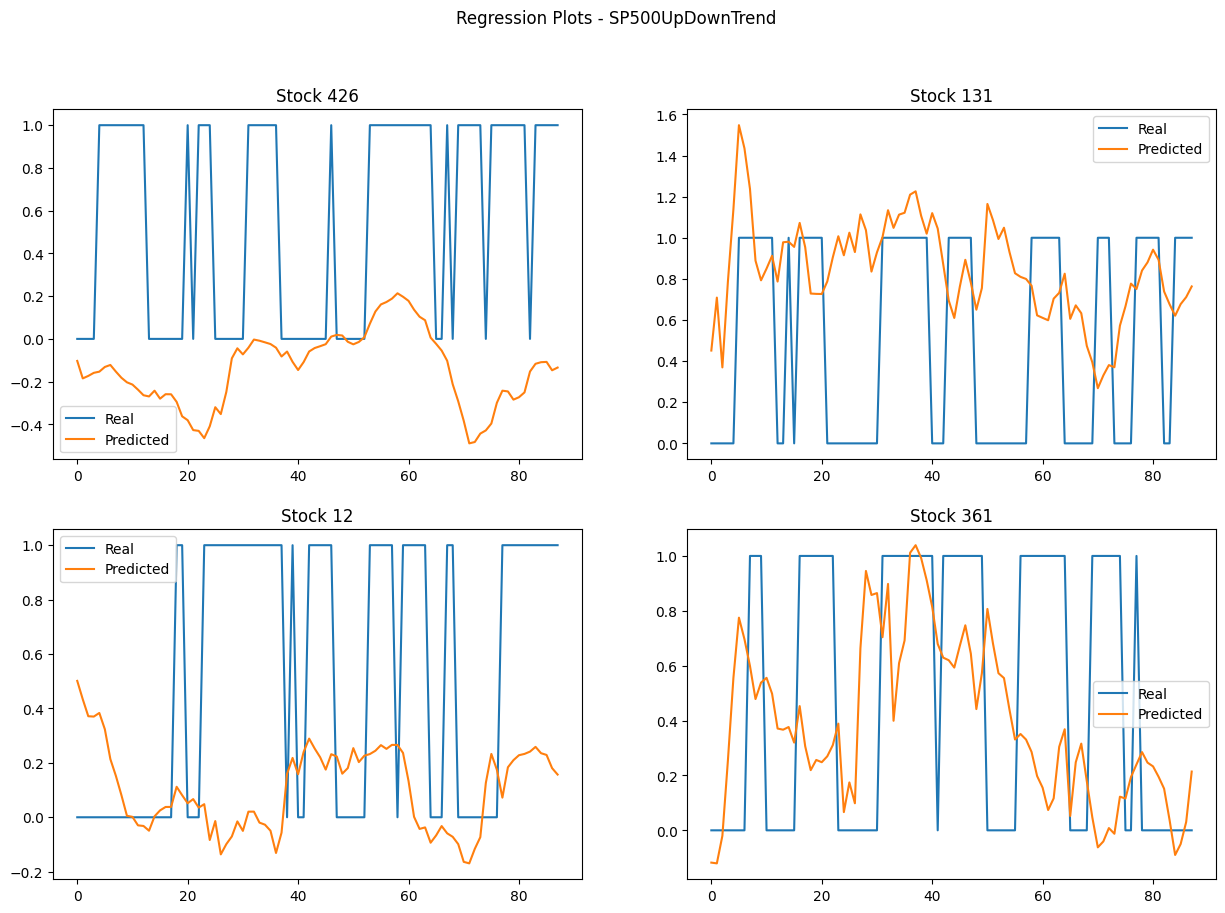

In [17]:
train(model, optimizer, criterion, train_dataloader,val_dataloader, test_dataloader, num_epochs, "SP500UpDownTrend", measure_acc=True, device = device)

In [17]:
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb).to(device)
model.load_state_dict(torch.load(f"../GNN-Stock/best_model/SP500UpDownTrend_31_10_16h39_A3TGCN.pt"))


<All keys matched successfully>

In [19]:
full_train_data = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)))
acc, cm = measure_accuracy(model, full_train_data, device=device), get_confusion_matrix(model, full_train_data, device = device)

print(f"Train accuracy: {acc * 100:.1f}%\nTrain confusion matrix:\n{cm}")

Train accuracy: 59.2%
Train confusion matrix:
[[ 52685 108780]
 [ 31121 150623]]


In [18]:
acc, cm = measure_accuracy(model, next(iter(train_dataloader)), device=device), get_confusion_matrix(model, next(iter(train_dataloader)), device=device)

print(f"Test accuracy: {acc * 100:.1f}%\nTest confusion matrix:\n{cm}")

Test accuracy: 59.6%
Test confusion matrix:
[[ 4651 10306]
 [ 2920 13547]]
